# Relation between CPU Cycles and Data Transmission Size

### Experiment Setup

1. Totally 9 nodes from `cloudlab` in the experiment. 1 amd64 node as the client and 8 arm64 nodes as the servers.

2. Machine Configuration

  **1 client node (machine type `xl170`)**
  
  ---
  
  - xl170    Intel Broadwell, 10 core, 1 disk
  - CPU      Ten-core Intel E5-2640v4 at 2.4 GHz
  - RAM      64GB ECC Memory (4x 16 GB DDR4-2400 DIMMs)
  - Disk     Intel DC S3520 480 GB 6G SATA SSD
  - NIC      Two Dual-port Mellanox ConnectX-4 25 GB NIC (PCIe v3.0, 8 lanes
  
  ---
  
  **8 server nodes (machine type `m400`)**
  
  ---
  
  - m400    64-bit ARM
  - CPU     Eight 64-bit ARMv8 (Atlas/A57) cores at 2.4 GHz (APM X-GENE)
  - RAM     64GB ECC Memory (8x 8 GB DDR3-1600 SO-DIMMs)
  - Disk    120 GB of flash (SATA3 / M.2, Micron M500)
  - NIC     Dual-port Mellanox ConnectX-3 10 GB NIC (PCIe v3.0, 8 lanes

  ---

3. Servers send data to the client using TCP protocol.

4. Select 1 of them as the `client` and the other 8 nodes are `servers`. 

5. The experiment network is an isolate network and separated from all other experiments.

6. The transmission size is the total amount of data received by the client. The amount of data sent by each server is inversely proportional to the number of active servers. Suppose the total transmission size is `1K`, in the case when using 2 servers, each server sends 512 bytes of data; in the case of 3 servers, the first server sends 342 bytes of data and the rest of two send 341 bytes of data so that the total transmission size is still 1KB.

7. The data sent by the server is read from a local file. The buffer used for reading from the file as well as sending to the network is size of 128KB. We don't use [zero copy](https://www.linuxjournal.com/article/6345) related system call to send the data as we want to simulate the servers are required to perform data filtering in the user space before sending the distilled result. No I/O bottleneck observed on the server nodes during the experiment.

8. The client uses the same number of processes as the number of active servers in eash test. Each process establishes a connection to a different server.

9. Right after each single test, all the active servers drop the filesystem cache using the following command (reference [drop_caches](https://www.kernel.org/doc/Documentation/sysctl/vm.txt#drop_caches))
   ```bash
   sync; echo 3 > /proc/sys/vm/drop_caches
   ```

10. The client caches up to 500MB of the latest received data in the memory. No memory bottleneck observed on the client node.

11. Each test (*receive X bytes of data from Y servers*) repeats 10 times.

12. The CPU cycle information is gathered from the output of [perf stat](http://man7.org/linux/man-pages/man1/perf-stat.1.html)

13. The bitrate is measured by the client and it is equals to
  ```
  number of bits of data received / the duration of receiving all the data in seconds
  ```

14. TCP segment retransmission rate < `4.63e-7`; The total number of TCP segments received in error is `0`

15. [Pyben-nio](https://github.com/ljishen/dockerfiles/tree/master/pyben-nio) is my home-made benchmark program written in Python.

In [1]:
from IPython.display import display, HTML

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
ROW_NAME_AVG = 'AVG'
ROW_NAME_STD = 'STD'

def gen_df(csv_file, header_col):
    FILE_PATH = '../backups/' + csv_file

    with open(FILE_PATH, 'r') as f:
        num_rows = f.readline().count(',')
    df = pd.read_csv(FILE_PATH, index_col=header_col, header=None,
                     names=range(1, num_rows - len(header_col) + 2)).T

    
    # Add the avrerage row and the standard deviation row 
    df = df.rename({num_rows - len(header_col) + 1: ROW_NAME_AVG})
    df.loc[ROW_NAME_STD] = np.nan

    num_data_raws = num_rows - len(header_col)
    for category in df.columns:
        df[category][ROW_NAME_AVG] = np.mean(df[category][:num_data_raws])
        df[category][ROW_NAME_STD] = np.std(df[category][:num_data_raws], ddof=1)

    display(HTML(df.to_html()))
    
    return df

In [3]:
def show_chart(csv_file):
    df = gen_df(csv_file, [0, 1, 2])

    # Start to draw the chart
    
    N = len({c[0] for c in df.columns})
    ind = np.arange(N)  # the x locations for the groups

    # Draw bins for Cycles
    fig, ax1 = plt.subplots()
    
    num_servs = len({c[1] for c in df.columns})
    bar_width = 1 / (num_servs + 2)
    
    cycle_bars = []
    for s in range(num_servs):
        bar = ax1.bar(ind + s / (num_servs + 2),
                            df.loc[ROW_NAME_AVG][2 * s::2 * num_servs],
                            width=bar_width,
                            yerr=df.loc[ROW_NAME_STD][2 * s::2 * num_servs])
        cycle_bars.append(bar)

    ax1.set_yscale('log')
    ax1.set_ylim(ymin=1e8)
    
    ax1_clr = 'r'
    ax1.set_ylabel(df.columns[0][2], color=ax1_clr)
    ax1.tick_params('y', colors=ax1_clr)


    # Draw lines for Bitrate
    ax2 = ax1.twinx()

    bitrate_bars = []
    for s in range(num_servs):
        bar = ax2.errorbar(ind + bar_width * (num_servs // 2),
                           df.loc[ROW_NAME_AVG][2 * s + 1::2 * num_servs],
                           yerr=df.loc[ROW_NAME_STD][2 * s + 1::2 * num_servs],
                           fmt='-o')
        bitrate_bars.append(bar)

    ax2_clr = 'b'
    ax2.set_ylabel(df.columns[1][2] + ' (bit/s)', color=ax2_clr)
    ax2.tick_params('y', colors=ax2_clr)

    # Change the size of figure
    # See https://stackoverflow.com/a/4306340
    fig.set_dpi(120)

    ax1.set_xlabel('Transmission Size (Bytes)')

    labels = [c[0] for c in df.columns][0::2 * num_servs]
    plt.xticks(ind + bar_width * (num_servs // 2), labels)
    
    type_legend = plt.legend([cycle_bars[0], bitrate_bars[0]],
                             [df.columns[0][2], df.columns[1][2]],
                            loc=2)
    plt.gca().add_artist(type_legend)
    ax1.legend(cycle_bars,
           [str(n) + ' servers' for n in range(1, num_servs + 1)],
           ncol=3,
           loc=8,
           bbox_to_anchor=(0.5, -0.4))
    
    
    benchmark = csv_file.split('/')[0]
    plt.title('CPU Cycles and Network Bandwidth on Client under Different Transmission Size \n(' + benchmark + ')', y=1.1)
    
    plt.savefig('../charts/remote_read_cycles_' + benchmark + '.png', bbox_inches='tight')
    plt.show()

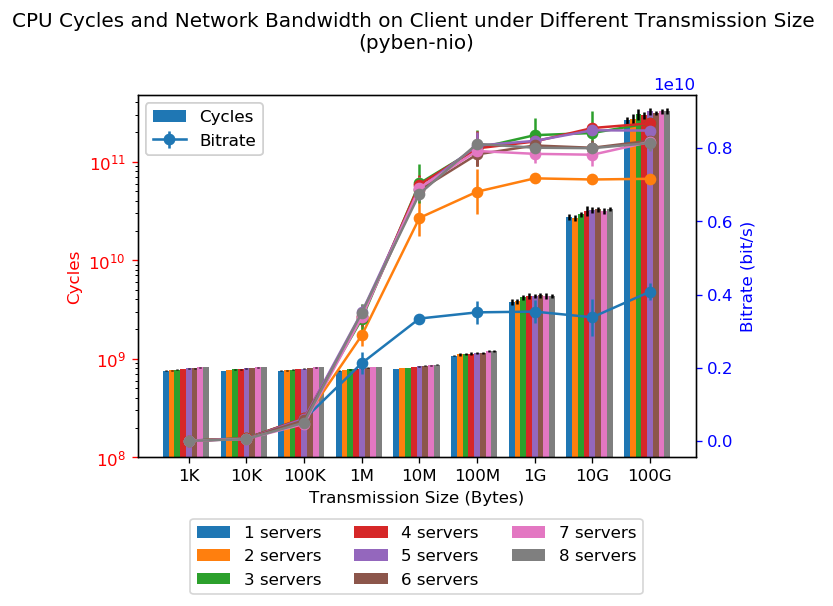

In [4]:
show_chart('pyben-nio/output_128K_8servs_autocpuset_arm/result.csv')